Семинарска работа по предметот **Вовед во науката за податоци**
<br>
Тема бр 9: Да се соберат податоци за цената на храната во САД за период од изминатите 4 години. За крај, да се направи benchmark
на три модели за предвидување на цената на најмалку 10 прехрамбени продукти. Резултатите соодветно да се
документираат и објаснат.

In [33]:
#Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np

# Чистење и подготовка на податоците

In [65]:
# Reading the csv file into a pandas Data Frame
df = pd.read_csv('/content/drive/MyDrive/VNP Seminarska/2019-2023 - BLS Data Series.csv')
df

,Item,Country,Currency,Rate,Jan\n2019,Feb\n2019,Mar\n2019,Apr\n2019,May\n2019,Jun\n2019,...,Mar\n2023,Apr\n2023,May\n2023,Jun\n2023,Jul\n2023,Aug\n2023,Sep\n2023,Oct\n2023,Nov\n2023,Dec\n2023
0,Bacon,USA,USD,per lb,5.518,5.502,5.608,5.552,5.812,5.878,...,6.613,6.549,6.339,6.224,6.236,6.502,7.083,7.223,6.899,6.774
1,Bananas,USA,USD,per lb,0.576,0.571,0.581,0.567,0.579,0.574,...,0.632,0.635,0.628,0.625,0.631,0.631,0.625,0.626,0.627,0.625
2,Bread,USA,USD,per lb,1.274,1.282,1.261,1.285,1.289,1.280,...,1.936,1.989,1.951,1.937,1.980,1.970,1.972,2.002,1.976,2.024
3,Chicken,USA,USD,per lb,1.473,1.486,1.468,1.463,1.479,1.590,...,1.868,1.873,1.920,1.953,1.891,1.958,1.901,1.926,1.976,1.955
4,Coffee,USA,USD,per lb,NaN,NaN,NaN,NaN,NaN,NaN,...,6.184,6.040,6.094,6.091,6.141,6.091,6.085,6.178,6.169,6.092
5,Eggs,USA,USD,per doz,1.554,1.557,1.544,1.463,1.362,1.203,...,3.446,3.270,2.666,2.219,2.094,2.043,2.065,2.072,2.138,2.507
6,Flour,USA,USD,per lb,0.439,0.443,0.445,0.434,0.454,0.448,...,0.546,0.542,0.544,0.551,0.564,0.566,0.565,0.562,0.541,0.538
7,Milk,USA,USD,per gal,2.913,2.900,2.944,2.980,2.963,3.054,...,4.098,4.042,4.042,3.985,3.971,3.927,3.965,3.927,3.997,4.008
8,Oranges,USA,USD,per lb,1.344,1.298,1.346,1.280,1.331,1.296,...,1.509,1.530,1.512,1.535,1.591,1.623,1.637,1.693,1.664,1.601
9,Rice,USA,USD,per lb,0.730,0.762,0.757,0.767,0.761,0.801,...,0.982,0.980,0.997,1.003,1.006,0.997,0.981,0.960,0.992,0.990


 Како што може да се забалежи од горенаведената табела станува збор за информации цени на прехранбени производи во САД меѓутоа истите не се во формат соодветен за анализа и предикција па затоа ќе ги преработиме со помош на функцијата melt() која што е дел од спектарот на функции подржани од pandas и служи за трансформирање на Data Frame од "wide" format (како што е прикажан погоре), во "long" format погоден за анализа.

In [35]:
# Melting the data for the project purposses i.e. to transform the data frame into a long format
data_melted = pd.melt(df, id_vars=['Item', 'Country', 'Currency', 'Rate'], var_name='Date', value_name='Price')
data_melted['Date'] = pd.to_datetime(data_melted['Date'])
data_melted

<ipython-input-35-62d0dc8ea26d>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_melted['Date'] = pd.to_datetime(data_melted['Date'])


,Item,Country,Currency,Rate,Date,Price
0,Bacon,USA,USD,per lb,2019-01-01,5.518
1,Bananas,USA,USD,per lb,2019-01-01,0.576
2,Bread,USA,USD,per lb,2019-01-01,1.274
3,Chicken,USA,USD,per lb,2019-01-01,1.473
4,Coffee,USA,USD,per lb,2019-01-01,NaN
...,...,...,...,...,...,...
595,Eggs,USA,USD,per doz,2023-12-01,2.507
596,Flour,USA,USD,per lb,2023-12-01,0.538
597,Milk,USA,USD,per gal,2023-12-01,4.008
598,Oranges,USA,USD,per lb,2023-12-01,1.601


Во овој момент го имаме датасетот во форматот во кој што сакаме меѓутоа за поголема читливост ќе го сортирам по колоните **Item** и **Date**

In [36]:
#Sorting the melted data by Item and Date so it is more readable
data = data_melted.sort_values(by=['Item', 'Date'])
data = data.reset_index(drop=True)
data.head()

,Item,Country,Currency,Rate,Date,Price
0,Bacon,USA,USD,per lb,2019-01-01,5.518
1,Bacon,USA,USD,per lb,2019-02-01,5.502
2,Bacon,USA,USD,per lb,2019-03-01,5.608
3,Bacon,USA,USD,per lb,2019-04-01,5.552
4,Bacon,USA,USD,per lb,2019-05-01,5.812


In [37]:
print("Unique valiues for the \"Country\" column: " + str(data['Country'].nunique()))
print("Unique valiues for the \"Currency\" column: " + str(data['Currency'].nunique()))

Unique valiues for the "Country" column: 1
Unique valiues for the "Currency" column: 1


Со оглед на тоа што во колоните "**Currency**" и "**Country**" имаме само 1 вредност која не би направила драстични промени во градењето на моделот и самата предикција па затоа ќе ги drop-неме.

In [38]:
data = data.drop(columns = ['Country', 'Currency'], axis=1)
data.head()

,Item,Rate,Date,Price
0,Bacon,per lb,2019-01-01,5.518
1,Bacon,per lb,2019-02-01,5.502
2,Bacon,per lb,2019-03-01,5.608
3,Bacon,per lb,2019-04-01,5.552
4,Bacon,per lb,2019-05-01,5.812


Ќе продолжиме со обработка на "**Date**" колоната односно креирање на 2 нови колони "**Year**" и "**Month**" и ќе ја избришеме колоната "**Date**" бидејќи не ни е потребна

In [39]:
# Extract features from the date
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

# Drop the original 'date' column as it's no longer needed
data.drop('Date', axis=1, inplace=True)
data.head()

,Item,Rate,Price,Year,Month
0,Bacon,per lb,5.518,2019,1
1,Bacon,per lb,5.502,2019,2
2,Bacon,per lb,5.608,2019,3
3,Bacon,per lb,5.552,2019,4
4,Bacon,per lb,5.812,2019,5


## Missing values

Откако завршивме со средување на форматот на датасетот, одиме со проверка за missing values

In [40]:
#Checking for missing values
print(data.isnull().sum())

Item      0
Rate      0
Price    22
Year      0
Month     0
dtype: int64


Како што може да се согледа од проверката missing values имаме само во колоната **Price**. Поради фактот што missing values имаме само во 1 од колоните нема потреба од визуелизации за да согледаме корелација и зависност меѓу вредностите кои недостасуваат од повеќе табели па затоа нема да правиме heatmap или пак некои други визуелизации на оваа тема.
<br>
<br>
Со оглед на тоа што **Price** колоната содржи вредности за цената на храната **во дадена временска серија и истите следат одреден тренд односно се слични од месец за месец**, најдобар начин за справување со овие missing values би била да се заменат истите со претходната или следната вредност од цените на самиот производ. За ова се одлучив вака а не во рамки на целиот датасет бидејќи постои опасност да земеме следна/претходна вредност која би била цена на друг производ од тој од кој што недостасува вредност па ова би било погрешно поради што има драстична разлика помеѓу рангот на цените на различните производи па би дошло до погрешни податоци

Со цел да го решиме проблемот со missing values како што е погоре наведено ке направам функција која се решава од missing values по производ ("Item")

In [41]:
def imputate_missing_value_by_item(item):
    # Filter the dataframe for the specific item
    item_df = data[data['Item'] == item].copy()

    # Check if there are any missing values in the 'Price' column
    if item_df['Price'].isnull().any():
        # If the first row has a missing value, use backward fill
        if pd.isnull(item_df['Price'].iloc[0]):
            item_df['Price'] = item_df['Price'].fillna(method='bfill')
        # Otherwise, use forward fill for other missing values
        else:
            item_df['Price'] = item_df['Price'].fillna(method='ffill')

    # Update the original dataframe with the filled values
    data.update(item_df)

    return data

In [42]:
for item in data['Item'].unique():
    data = imputate_missing_value_by_item(item)

<ipython-input-41-7c642bb7b139>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_df['Price'] = item_df['Price'].fillna(method='ffill')
<ipython-input-41-7c642bb7b139>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  item_df['Price'] = item_df['Price'].fillna(method='bfill')


In [43]:
#Checking for missing values
print(data.isnull().sum())

Item     0
Rate     0
Price    0
Year     0
Month    0
dtype: int64


In [44]:
for item in data['Item'].unique():
  print("Description about the item: " + item)
  print(data[data['Item'] == item].describe())
  print("\n")

Description about the item: Bacon
           Price         Year      Month
count  60.000000    60.000000  60.000000
mean    6.358783  2021.000000   6.500000
std     0.745350     1.426148   3.481184
min     5.257000  2019.000000   1.000000
25%     5.644500  2020.000000   3.750000
50%     6.287500  2021.000000   6.500000
75%     7.123500  2022.000000   9.250000
max     7.608000  2023.000000  12.000000


Description about the item: Bananas
           Price         Year      Month
count  60.000000    60.000000  60.000000
mean    0.603700  2021.000000   6.500000
std     0.026995     1.426148   3.481184
min     0.567000  2019.000000   1.000000
25%     0.576750  2020.000000   3.750000
50%     0.597000  2021.000000   6.500000
75%     0.630250  2022.000000   9.250000
max     0.643000  2023.000000  12.000000


Description about the item: Bread
           Price         Year      Month
count  60.000000    60.000000  60.000000
mean    1.586650  2021.000000   6.500000
std     0.236969     1.426148  

## Визуелизација на податоците

In [45]:
def show_price(item, color):
  plt.figure(figsize=(10, 3))
  plt.plot(data[data['Item'] == item]['Price'], color = color)
  plt.title(item + ' price', fontsize=15)
  plt.ylabel('Price in USD')
  plt.gca().axes.xaxis.set_ticklabels([])
  plt.tight_layout()
  plt.show()

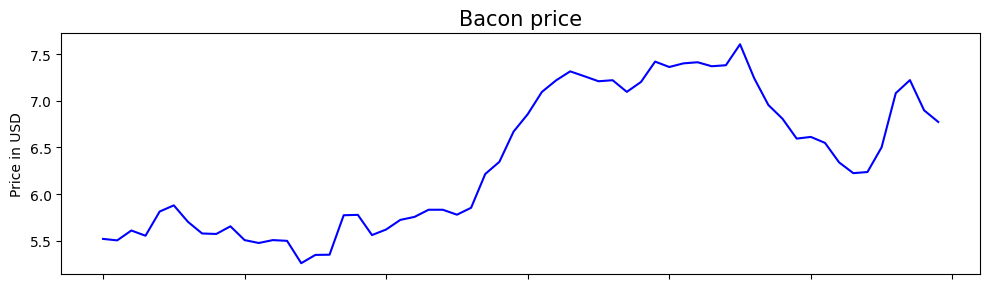

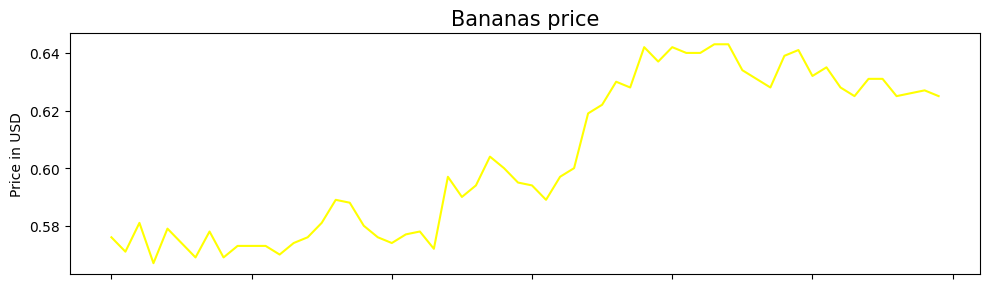

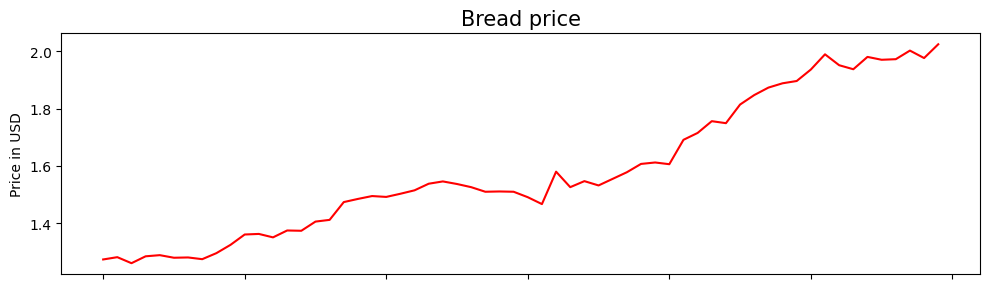

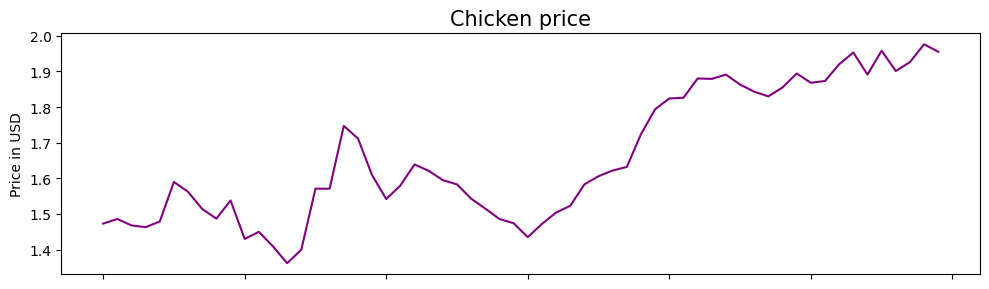

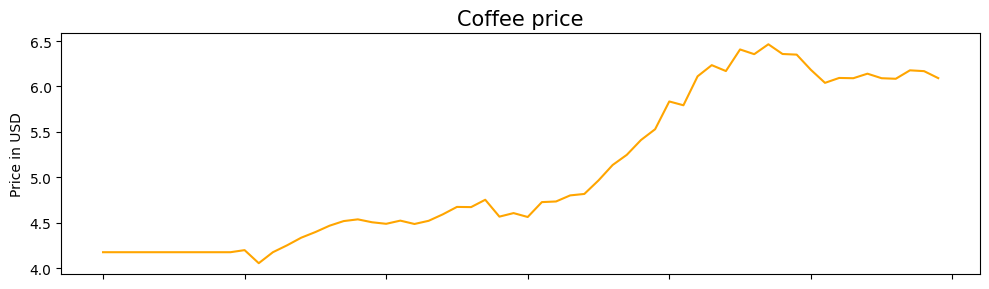

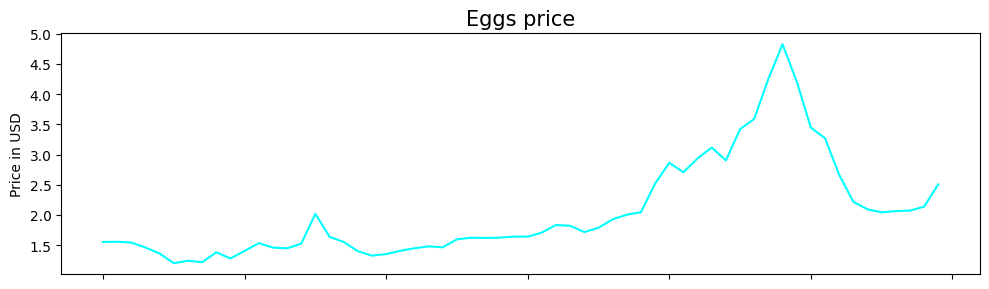

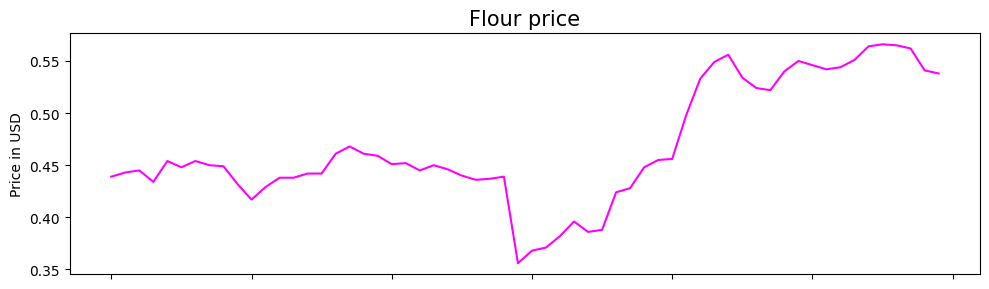

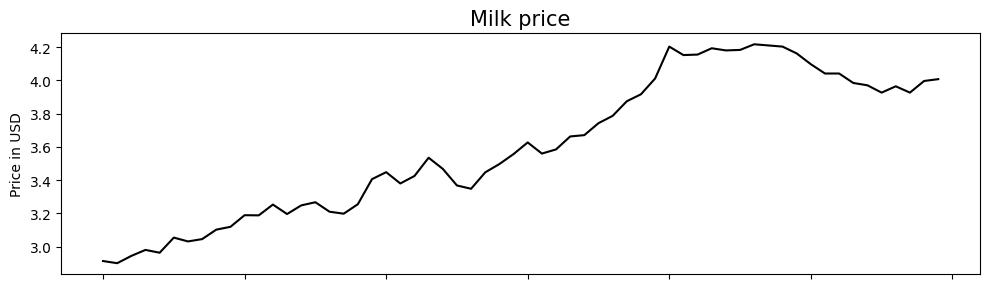

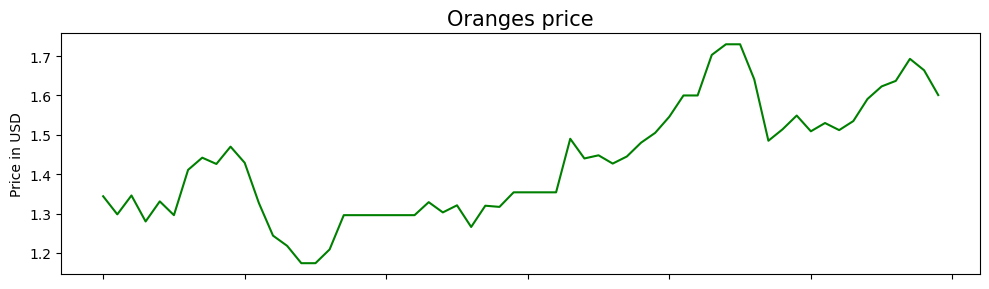

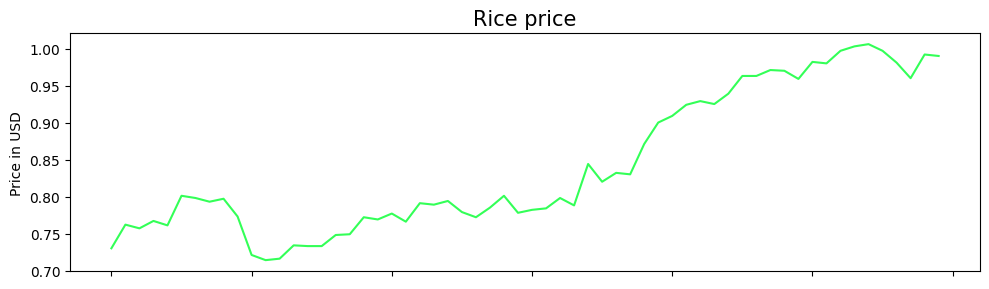

In [46]:
colors = ['blue', 'yellow', 'red', 'purple', 'orange', 'cyan', 'magenta', 'black', 'green', '#33FF57']
for i in range(0, 10):
    show_price(data['Item'].unique()[i], colors[i])

## Encoding the categorical data

In [48]:
print("Unique valiues for the \"Item\" column: " + str(data['Item'].nunique()))
print("Unique valiues for the \"Rate\" column: " + str(data['Rate'].nunique()))

Unique valiues for the "Item" column: 10
Unique valiues for the "Rate" column: 3


Поради фактот што во датасетот имаме категориски податоци ќе мораме истите да ги енкодираме бидејќи не можеме да работиме со нив како такви. За енкодирање на податоците се одлучив да го користам методот "Label Encoding" поради фактот што имаме само 10 unique вредности за колоната "**Item**" и 3 за колоната "**Rate**" (проверката погоре). Label Encoding методот претставува метод на енкодирање на категориски податоци каде што за секоја вредност на податоците им задава нов index.
<br>
<br>
Вредностите во колоната "**Rate**" претставуваат ordinal categorical data па за нив е и правилно да се искористи Label Encoder механизмот за енкодирање на категориските податоци.
<br>
<br>
За колоната "**Item**", иако можеби станува збор за nominal categorical data се одлучив за користење на custom Label Encoder со употреба на Dictionary со цел на крајот по тренирање на моделите да ги вратам правилните имиња на продуктите за да ги прикажам резултатите поубаво

In [49]:
le = LabelEncoder()
data['Rate'] = le.fit_transform(data['Rate'])
data.head()

,Item,Rate,Price,Year,Month
0,Bacon,2,5.518,2019,1
1,Bacon,2,5.502,2019,2
2,Bacon,2,5.608,2019,3
3,Bacon,2,5.552,2019,4
4,Bacon,2,5.812,2019,5


In [50]:
classes = list(data['Item'].unique())

dict = {}
for i in range(0,len(classes)):
    dict[classes[i]] = i
dict

{'Bacon': 0,
 'Bananas': 1,
 'Bread': 2,
 'Chicken': 3,
 'Coffee': 4,
 'Eggs': 5,
 'Flour': 6,
 'Milk': 7,
 'Oranges': 8,
 'Rice': 9}

In [51]:
data['Item'] = [dict[item] for item in data['Item']]
data.head()

,Item,Rate,Price,Year,Month
0,0,2,5.518,2019,1
1,0,2,5.502,2019,2
2,0,2,5.608,2019,3
3,0,2,5.552,2019,4
4,0,2,5.812,2019,5


In [52]:
def get_item_name(item_value):
  item_name = [key for key, val in dict.items() if val == item_value][0]
  return item_name

# Градење модели за предикција

In [53]:
def add_lag_by_item(item_name):
    df_item = data[data['Item'] == item_name].copy()

    df_item['Lag_1'] = df_item['Price'].shift(1)
    df_item['Lag_2'] = df_item['Price'].shift(2)

    df_item.dropna(inplace=True)

    return df_item

In [54]:
data = pd.concat([add_lag_by_item(item) for item in data['Item'].unique()])
data.head()

,Item,Rate,Price,Year,Month,Lag_1,Lag_2
2,0,2,5.608,2019,3,5.502,5.518
3,0,2,5.552,2019,4,5.608,5.502
4,0,2,5.812,2019,5,5.552,5.608
5,0,2,5.878,2019,6,5.812,5.552
6,0,2,5.701,2019,7,5.878,5.812


Во овој момент започнуваме со поделба на множеството на test и train множества па за таа цел бидејќи би креирале модели за предикција за секој тип на храна посебно, направив функција каде што само потребно е да се подаде името на производот и датасетот.
<br><br>
За таргет колона e избрана колоната "**Price**" бидејќи целта на задачата е да предвидат цените на различните производи

In [55]:
def split_data_by_item(item_num):
    df_item = data[data['Item'] == item_num].copy()

    x = df_item[['Item', 'Rate', 'Year', 'Month', 'Lag_1', 'Lag_2']]
    y = df_item['Price']

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

    return X_train, X_test, Y_train, Y_test

За модели на предвидување ги одбрав следниве

*   Linear Regression <br>
*   Random Forest Regression <br>
*   XGBoost Regression <br>



In [56]:
def linear_regression(X_train, X_test, Y_train, Y_test, item_value):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, Y_test, color='red', label='Test Values')
    plt.scatter(Y_test, y_pred, color='blue', label='Predicted Values')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='black', linestyle='--', linewidth=2)
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values')
    plt.title('Test vs Predicted Values for ' + get_item_name(item_value))
    plt.legend()
    plt.show()

    return mse, r2, mae


In [57]:
def random_forest_regressor(X_train, X_test, Y_train, Y_test, item_value):
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    #Metrics
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, Y_test, color='red', label='Test Values')
    plt.scatter(Y_test, y_pred, color='blue', label='Predicted Values')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='black', linestyle='--', linewidth=2)
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values')
    plt.title('Random Forest: Test vs Predicted Values for ' + get_item_name(item_value))
    plt.legend()
    plt.show()

    return mse, r2, mae


In [58]:
def xgb_regressor(X_train, X_test, Y_train, Y_test, item_value):
    model = xgb.XGBRegressor(random_state=42)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(Y_test, Y_test, color='red', label='Test Values')
    plt.scatter(Y_test, y_pred, color='blue', label='Predicted Values')
    plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='black', linestyle='--', linewidth=2)
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values')
    plt.title('XGBoost: Test vs Predicted Values for ' + get_item_name(item_value))
    plt.legend()
    plt.show()

    return mse, r2, mae

Следнава функција служи за пресметување на успешноста на секој модел при работа со исти test и train множества по "**Item**" се со цел да биде поверодостојно истражувањето

In [59]:
def training_models_by_item(item_num):
  X_train, X_test, Y_train, Y_test = split_data_by_item(item_num)

  #Linear regression
  mse_linear, r2_linear, mae_linear= linear_regression(X_train, X_test, Y_train, Y_test, item_num)

  #Random forest regression
  mse_random_forest, r2_random_forest, mae_random_forest = random_forest_regressor(X_train, X_test, Y_train, Y_test, item_num)

  #XGBoost regression
  mse_xgb, r2_xgb, mae_xgb = xgb_regressor(X_train, X_test, Y_train, Y_test, item_num)

  # Metrics of the models
  mse_values = [mse_linear, mse_random_forest, mse_xgb]
  rmse_values = [np.sqrt(mse_linear), np.sqrt(mse_random_forest), np.sqrt(mse_xgb)]
  r2_values = [r2_linear, r2_random_forest, r2_xgb]
  mae_values = [mae_linear, mae_random_forest, mae_xgb]

  return rmse_values, r2_values, mae_values

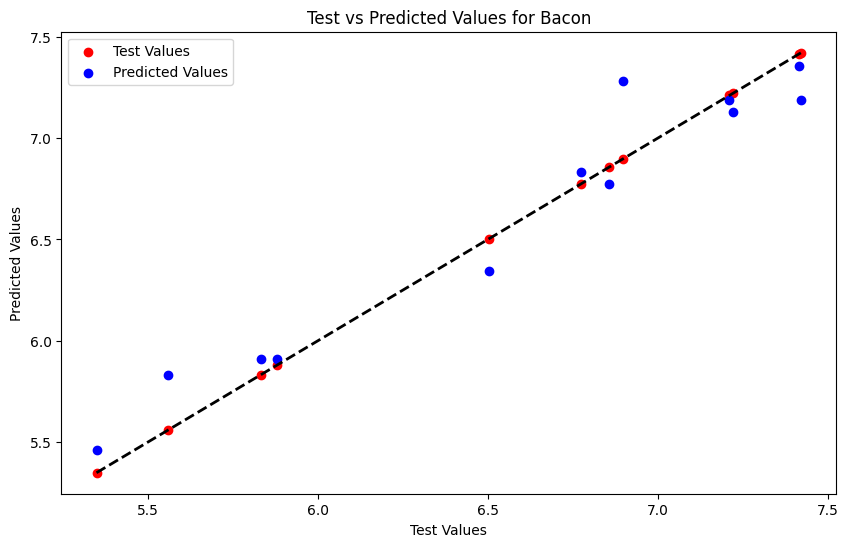

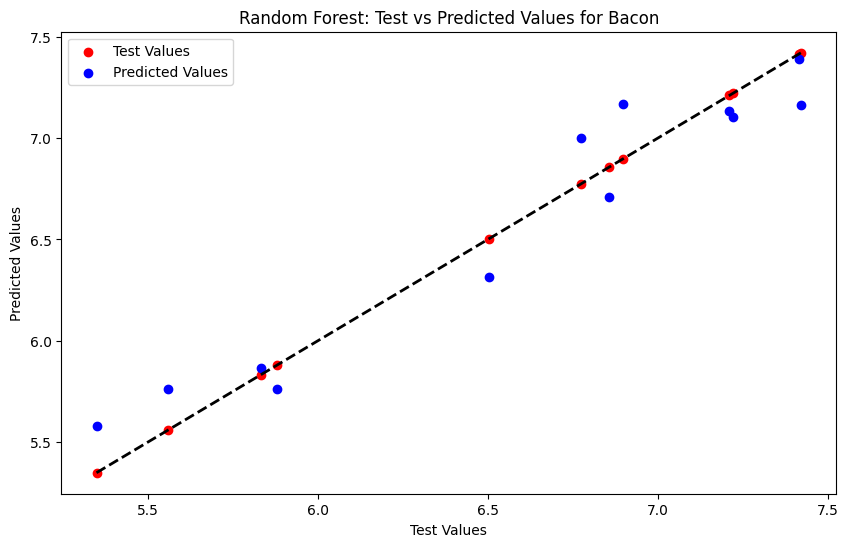

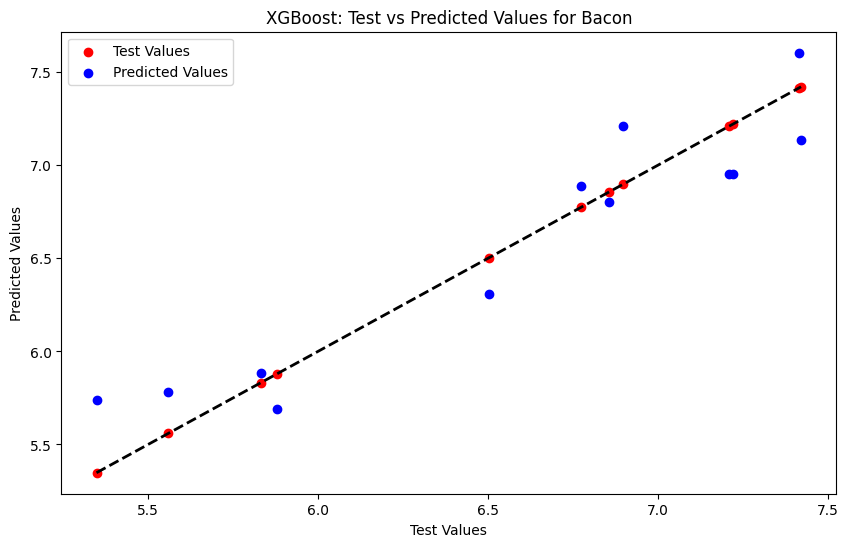

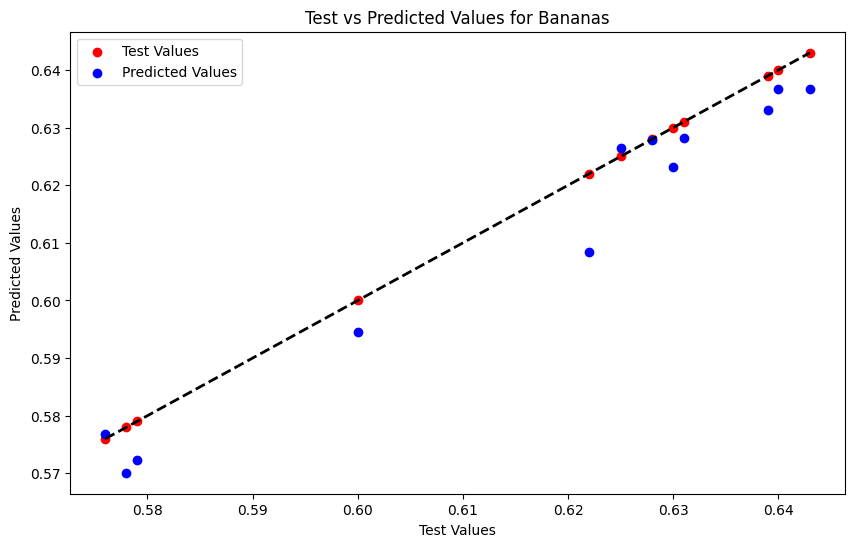

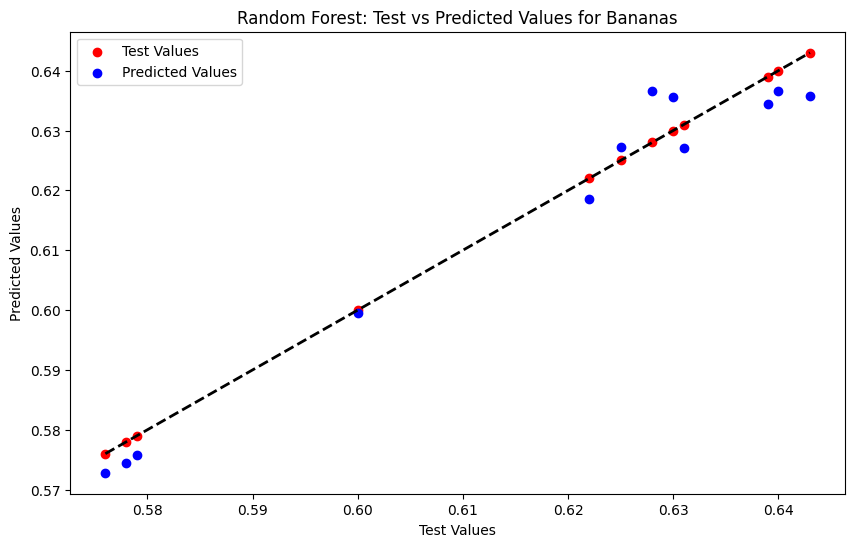

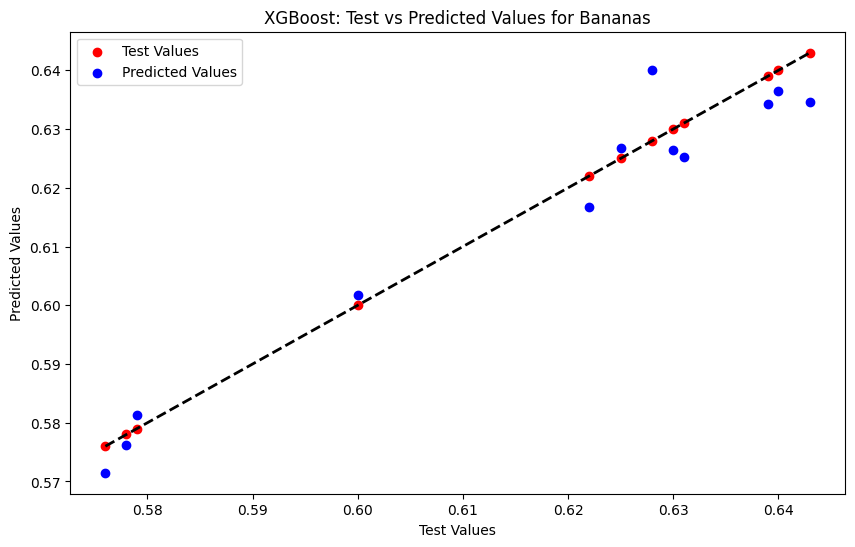

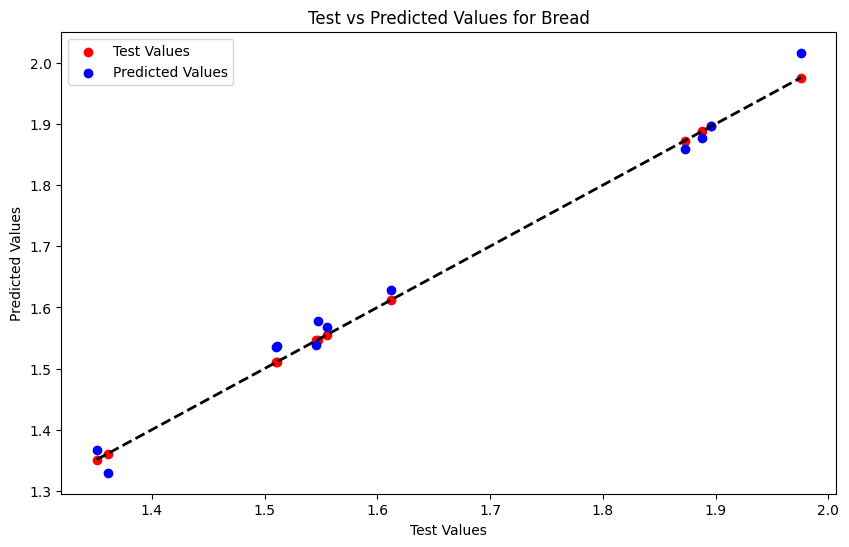

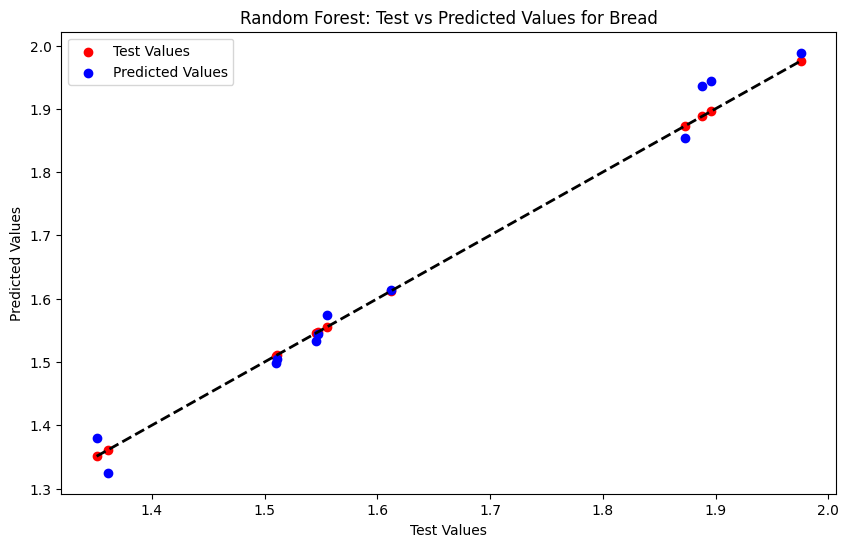

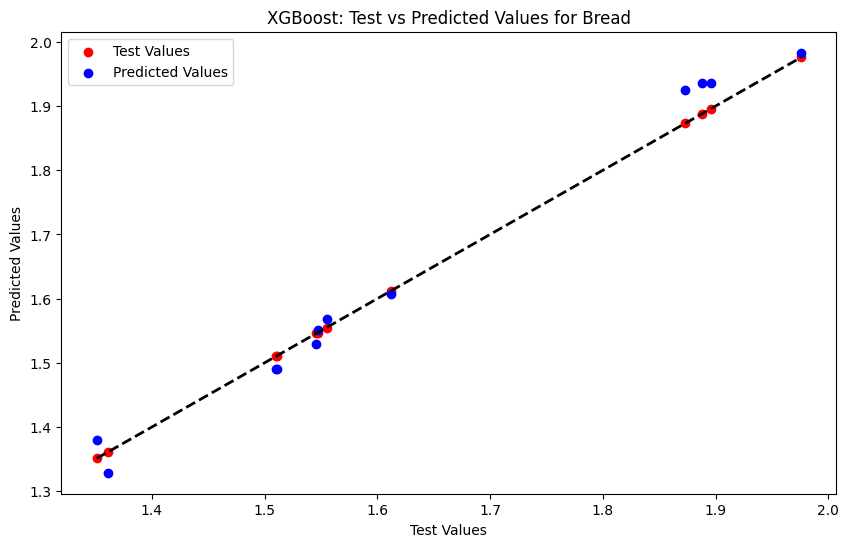

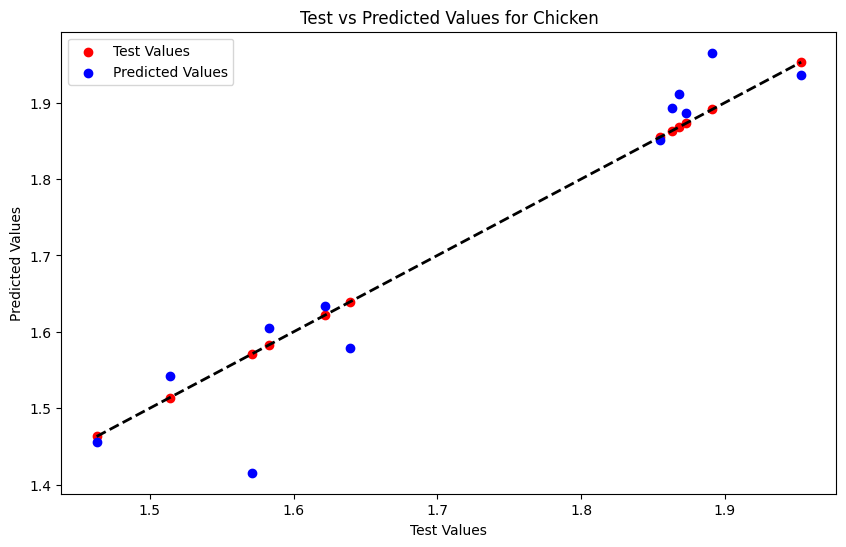

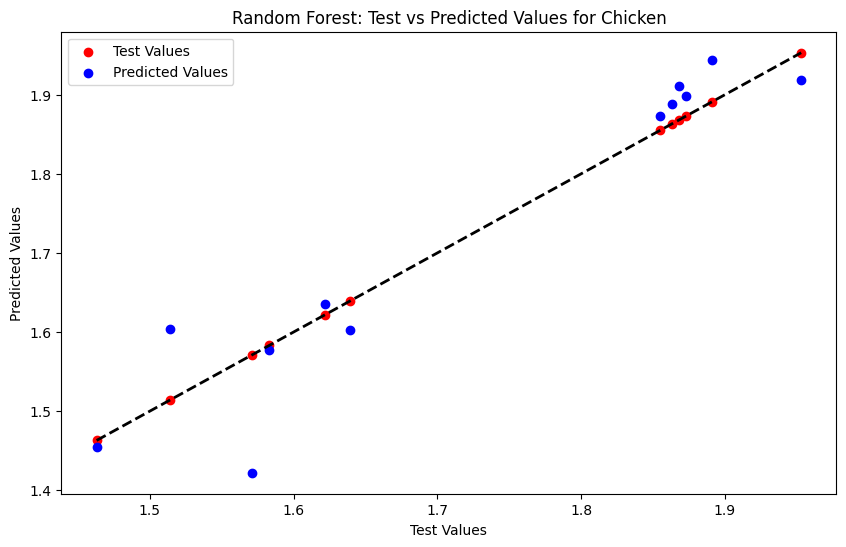

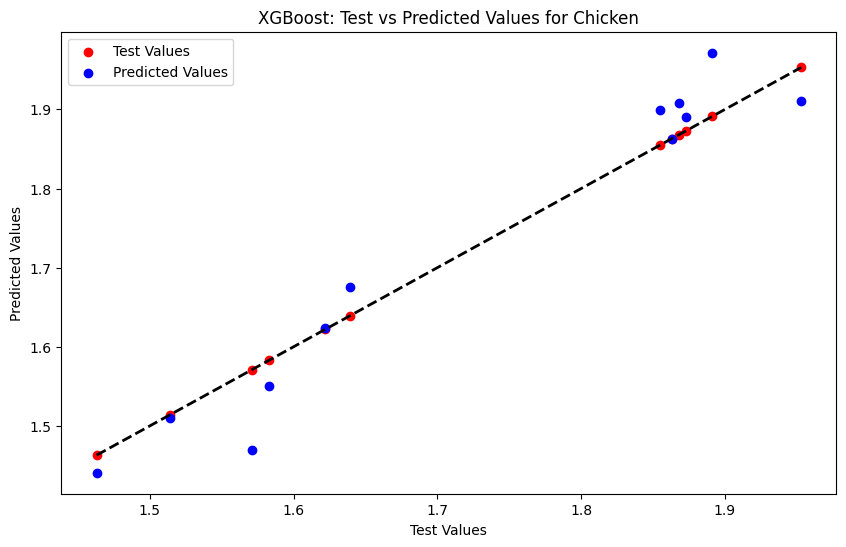

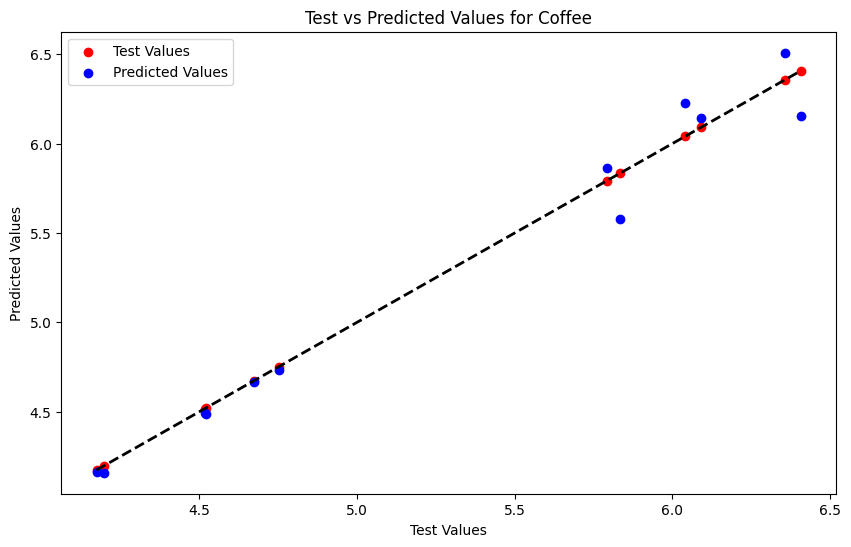

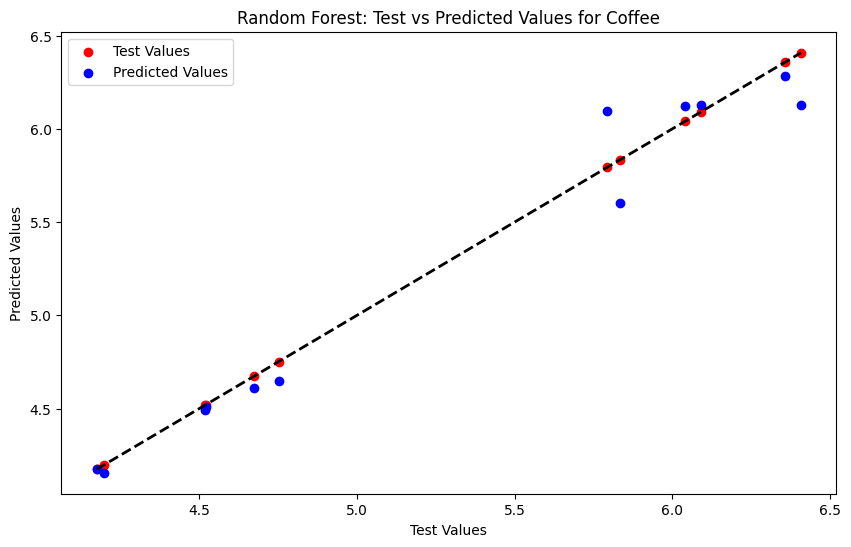

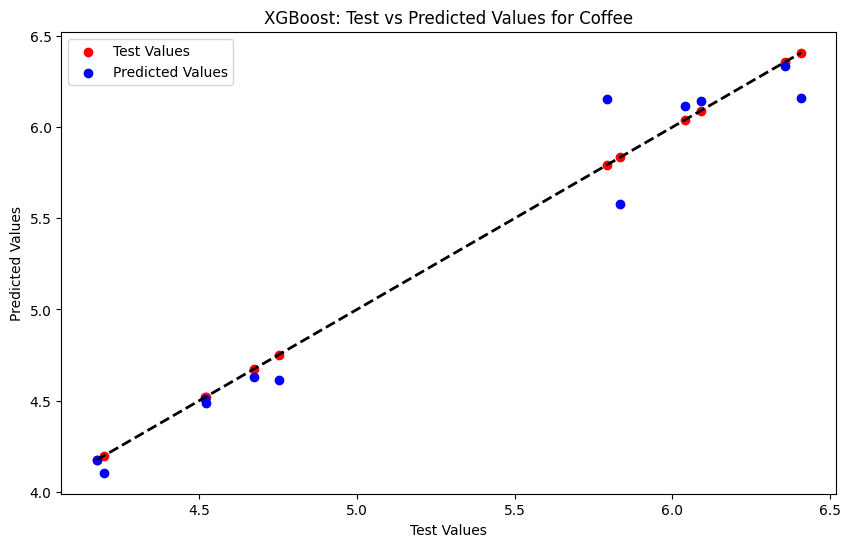

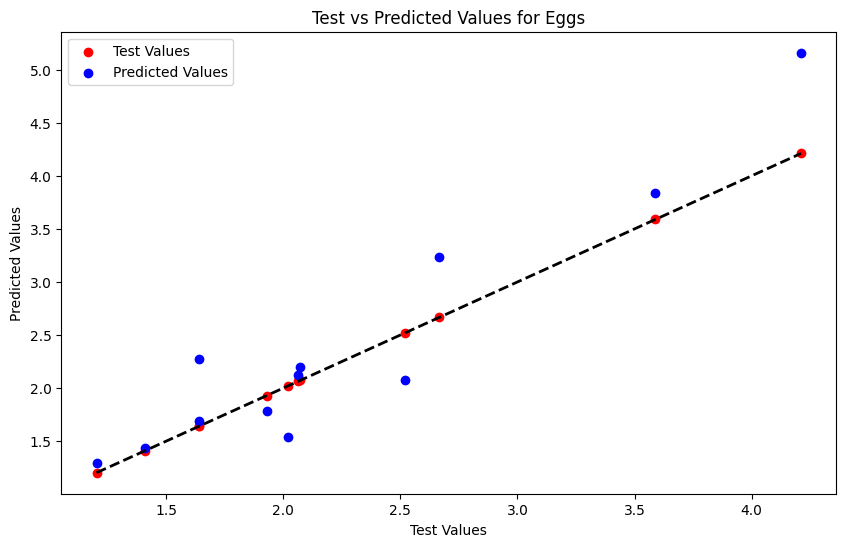

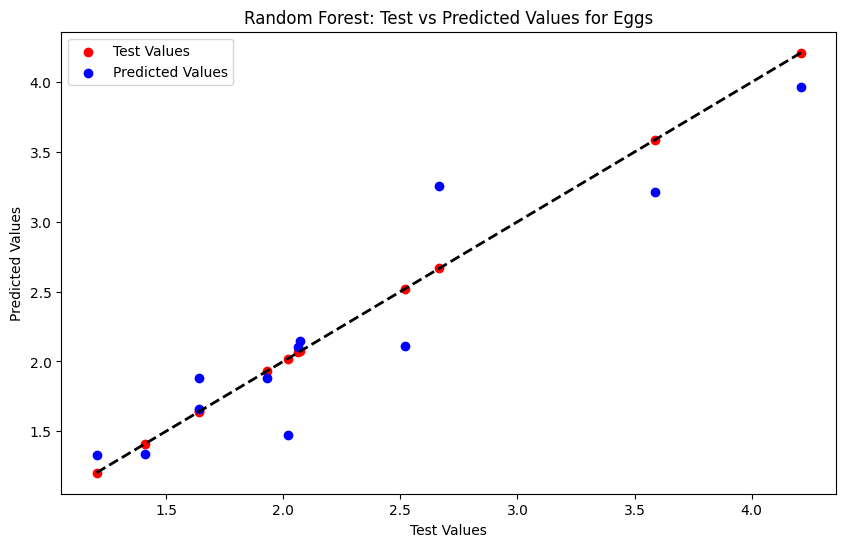

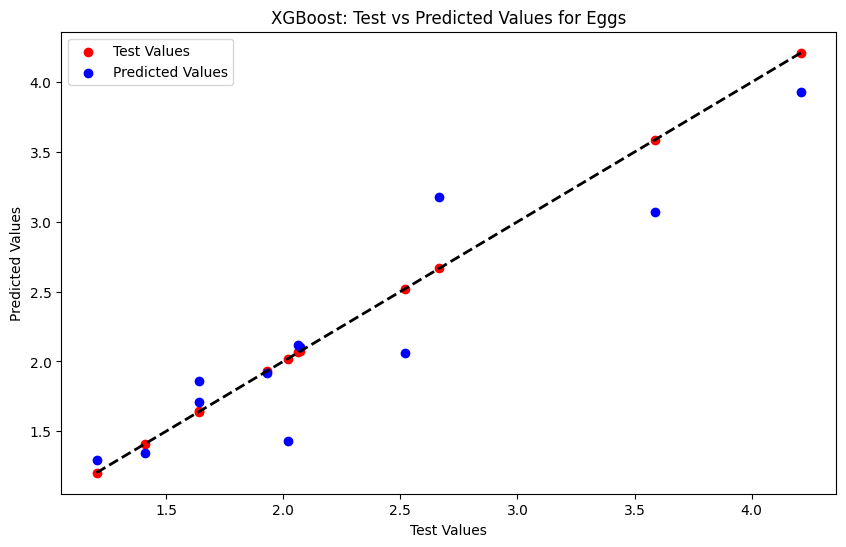

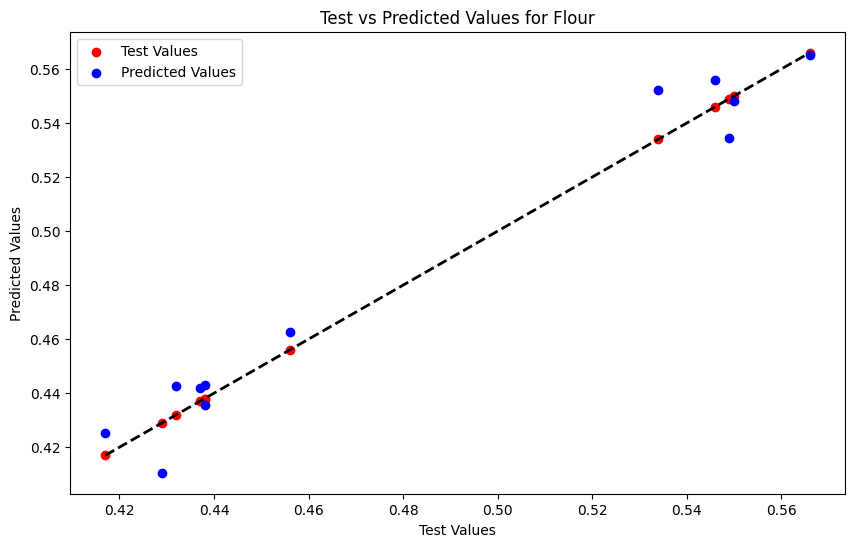

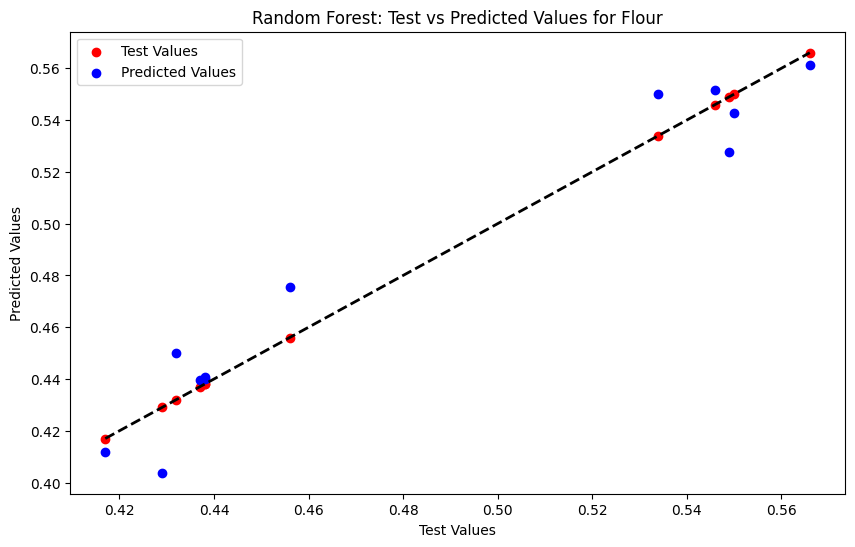

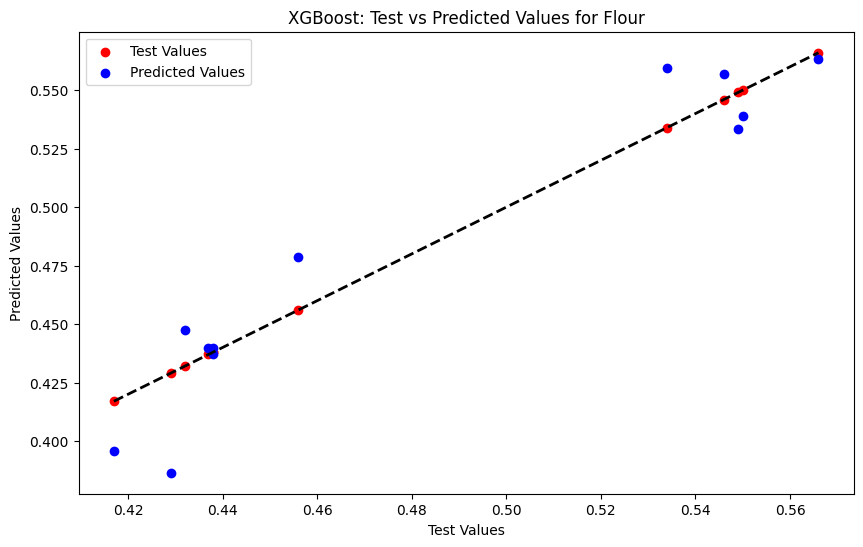

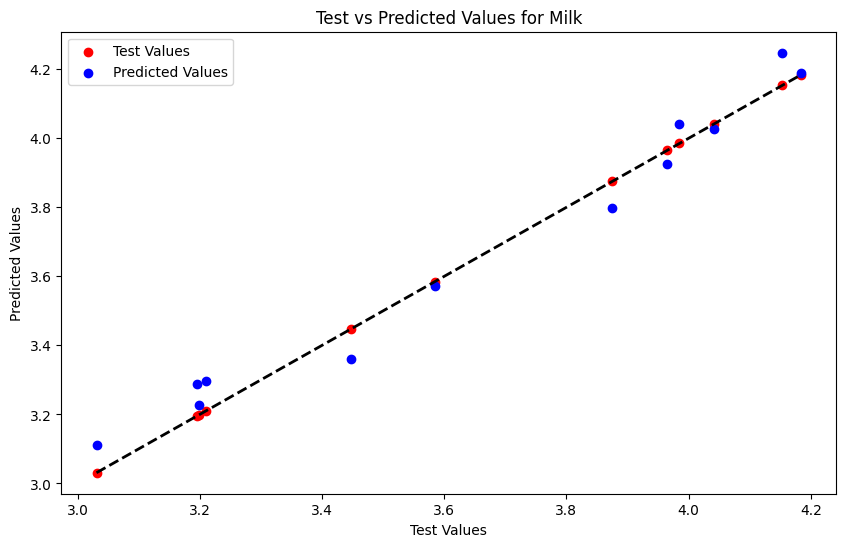

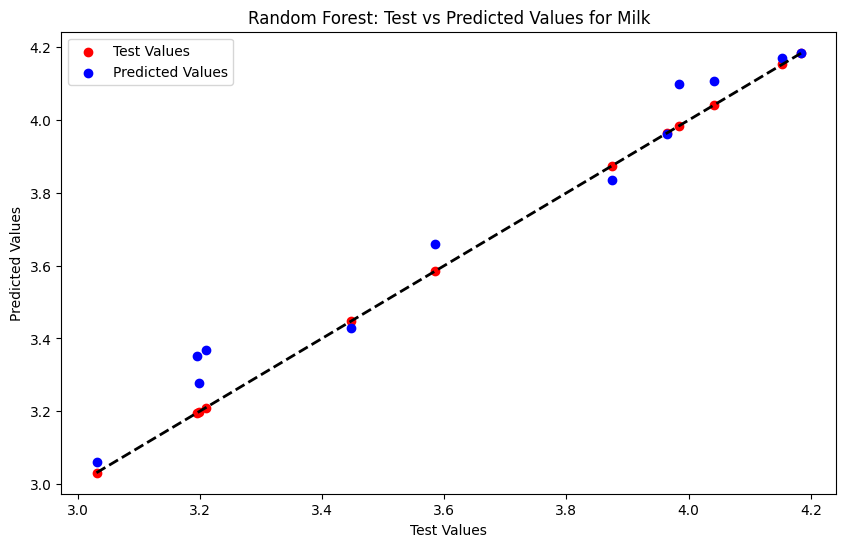

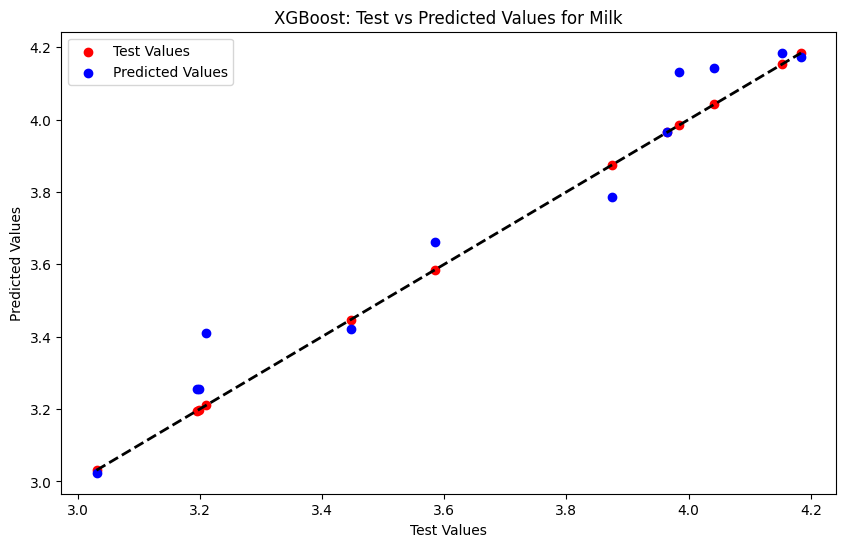

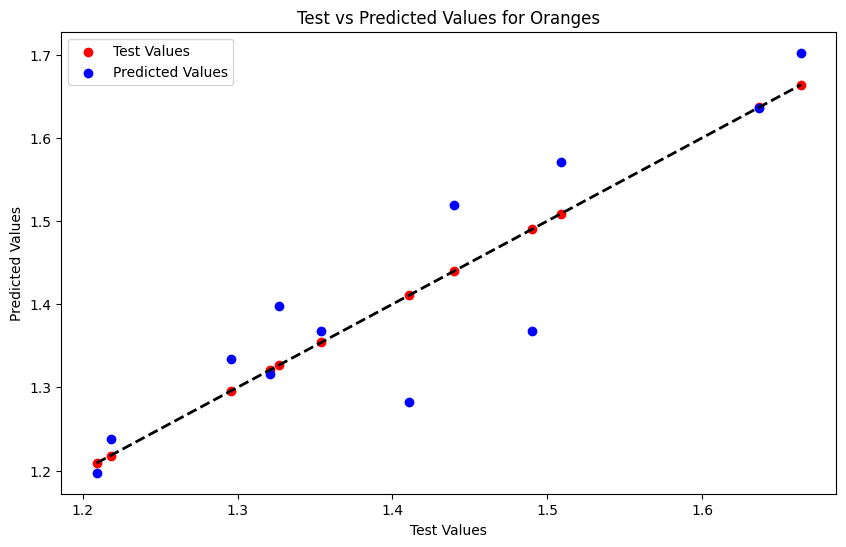

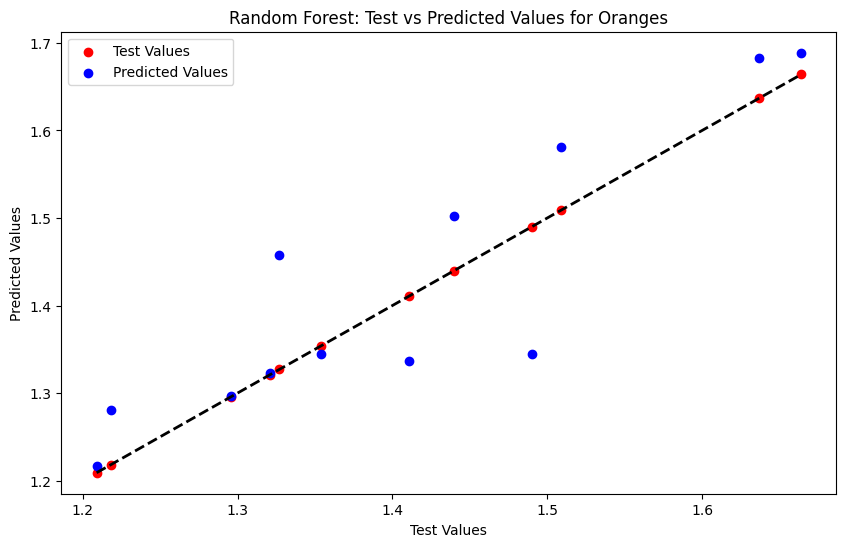

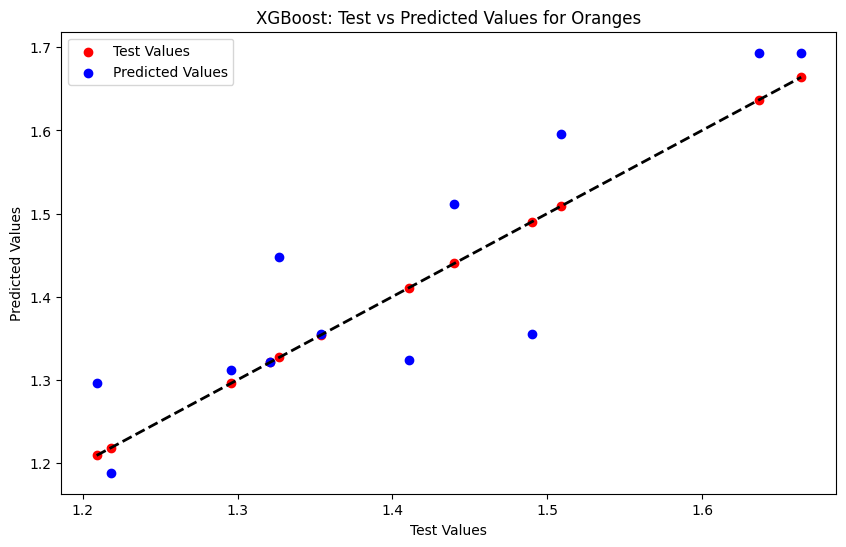

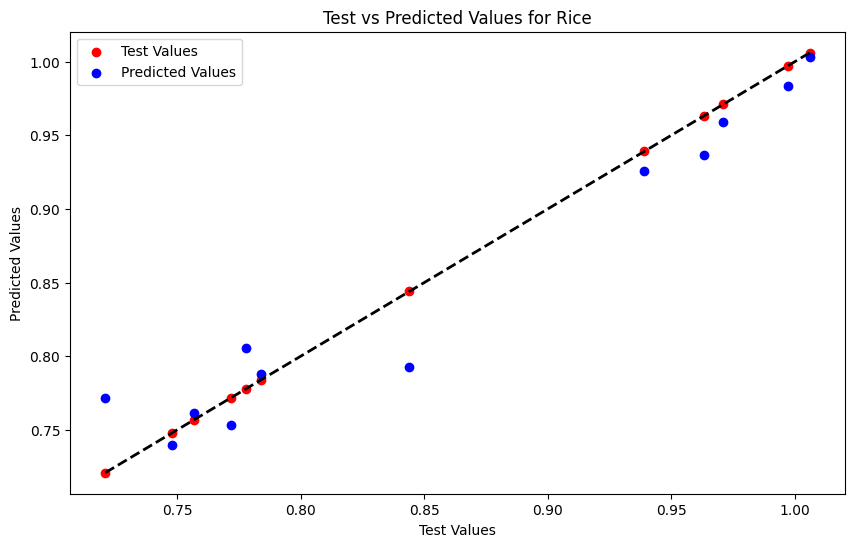

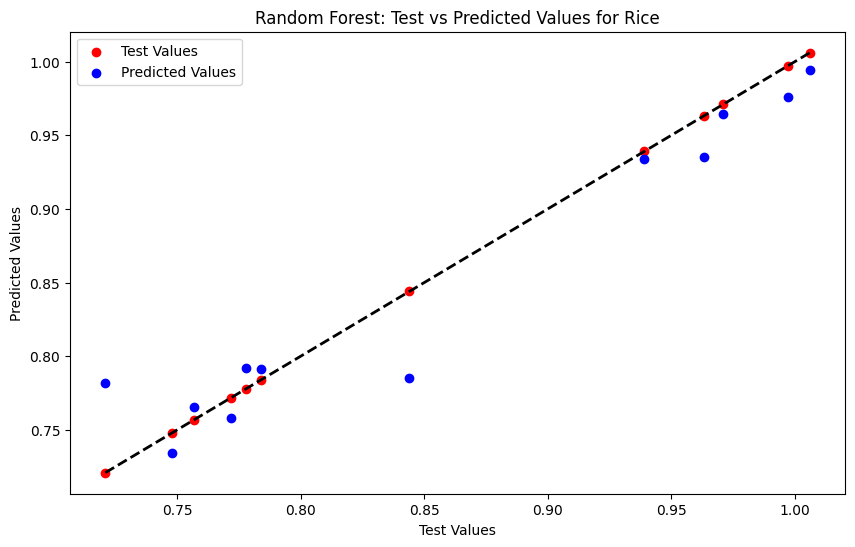

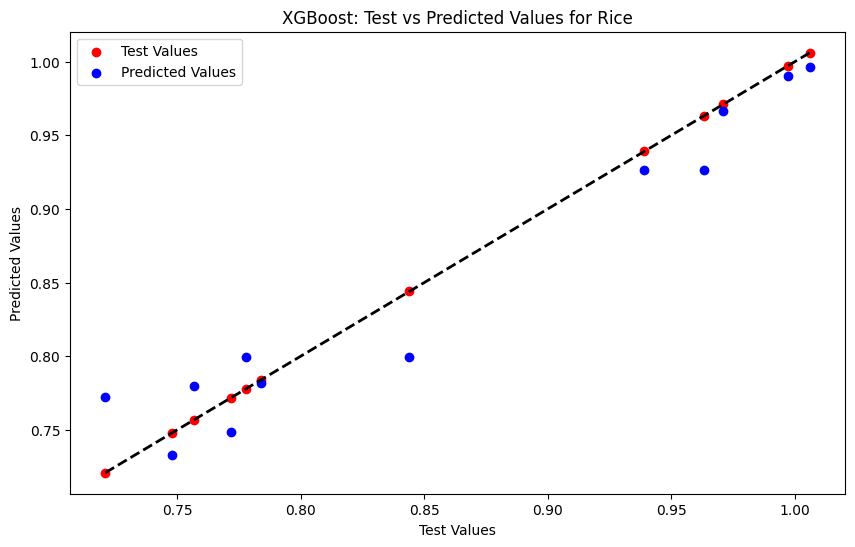

In [60]:
rmse_dict = []
r2_dict = []
mae_dict = []

for i in range(0, 10):
    rmse_values, r2_values, mae_values = training_models_by_item(i)
    rmse_dict.append({get_item_name(i) : {rmse_values[0], rmse_values[1], rmse_values[2]}})
    r2_dict.append({get_item_name(i) : {r2_values[0], r2_values[1], r2_values[2]}})
    mae_dict.append({get_item_name(i) : {mae_values[0], mae_values[1], mae_values[2]}})

За споредба помеѓу успешноста на моделите ќе ги користиме следниве метрики
 бидејќи обезбедува  

* RMSE (Mean Squared Error)<br> - Метрика која ни дава до знаење колкu се далеку предикциите од реалните вредности.

* R2<br> - Метрика која искажува колку добро предикциите на моделот се поклопуваат со реалните податоци.

* MAE<br> - Метрика која ја пресметува средната вредност на магнитудата на грешките од предикциите.

In [61]:
def create_dataset_for_metric(dictionary, metric):
  models = ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression']

  df_data = {get_item_name(i) : [] for i in range(len(dictionary))}

  for i, item_data in enumerate(dictionary):
      item_name, values = list(item_data.items())[0]
      sorted_values = sorted(values)

      for j, model in enumerate(models):
          if j >= len(df_data[item_name]):
              df_data[item_name].append(sorted_values[j])
          else:
              df_data[item_name][j] = sorted_values[j]

  df_to_return = pd.DataFrame(df_data, index=models)
  df_to_return['Average ' + metric] = df_to_return.mean(axis=1)

  return df_to_return;

In [62]:
df_rmse = create_dataset_for_metric(rmse_dict, "RMSE")
df_rmse

,Bacon,Bananas,Bread,Chicken,Coffee,Eggs,Flour,Milk,Oranges,Rice,Average RMSE
Linear Regression,0.168999,0.004614,0.022228,0.046018,0.129026,0.304257,0.010315,0.065208,0.064609,0.025230,0.084050
Random Forest Regression,0.177324,0.005483,0.025699,0.056207,0.144880,0.320800,0.013575,0.082685,0.070577,0.025857,0.092309
XGBoost Regression,0.232435,0.006224,0.028490,0.057074,0.157483,0.424937,0.018607,0.088617,0.074030,0.027786,0.111568


In [63]:
df_r2 = create_dataset_for_metric(r2_dict, "R2")
df_r2

,Bacon,Bananas,Bread,Chicken,Coffee,Eggs,Flour,Milk,Oranges,Rice,Average R2
Linear Regression,0.892888,0.935294,0.981064,0.882575,0.964755,0.749599,0.893667,0.952552,0.727333,0.929862,0.890959
Random Forest Regression,0.937660,0.949783,0.984593,0.886116,0.970170,0.857289,0.943399,0.958692,0.752178,0.939265,0.917914
XGBoost Regression,0.943376,0.964447,0.988474,0.923661,0.976342,0.871629,0.967322,0.974309,0.792317,0.942176,0.934405


In [64]:
df_mae = create_dataset_for_metric(mae_dict, "MAE")
df_mae

,Bacon,Bananas,Bread,Chicken,Coffee,Eggs,Flour,Milk,Oranges,Rice,Average MAE
Linear Regression,0.131970,0.004133,0.019355,0.035297,0.092207,0.232102,0.008525,0.056478,0.049191,0.019409,0.064867
Random Forest Regression,0.158078,0.004637,0.020486,0.038734,0.103723,0.241135,0.010867,0.063344,0.053262,0.020770,0.071504
XGBoost Regression,0.210922,0.005111,0.023853,0.041667,0.111108,0.318029,0.014405,0.067437,0.060085,0.020886,0.087350


Заклучок:
<br>
Mоделот на линеарна регресија ги искажува најдобрите перформанси во рамки на RMSE, MAE и R² метриките, што значи дека ги дава најпрецизните предикции